# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1/(1+np.exp(-X@weights.T))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = np.linalg.norm(weights)/(2*self.C)
        N = len(y)
        for j in range(N):
            loss += np.log(1+np.exp(-(weights@x[j])*y[j]))
        loss = loss/N
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_history = []
        self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
        for i in range(self.max_iter):
            N=len(y)
            delta = np.zeros(num_features)
            for j in range(N):
                delta += y[j]*X_ext[j, :]*(1-(1/(1+np.exp(-(self.weights_@X_ext[j])*y[j]))))
            delta = delta / N
            delta -= self.weights_/self.C
            self.weights_ += self.eta * delta
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(self.weights_) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        y = -2*(self.predict_proba(X) < 0.5)+1
        return y

In [5]:
from sklearn import datasets
from sklearn import metrics

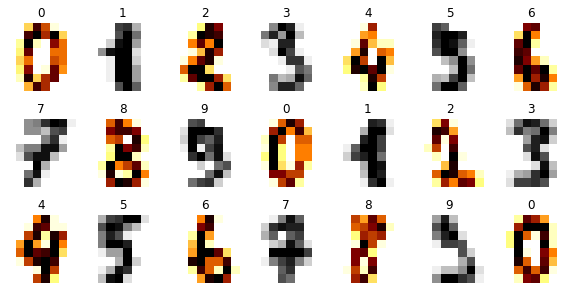

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


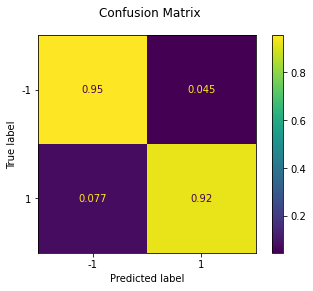

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0.5, 1.0, 'Loss history')

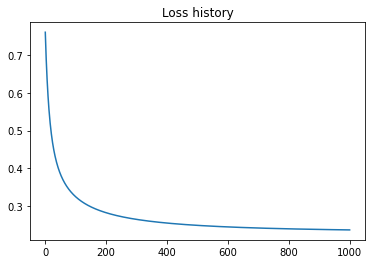

In [18]:
## your code
loss = model.loss_history
plt.plot(loss)
plt.title("Loss history")

As expected, loss decreases in each iteration.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


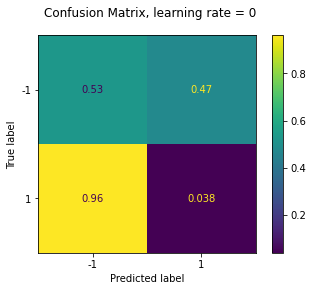

0.2894919972164231
0.2777777777777778


C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


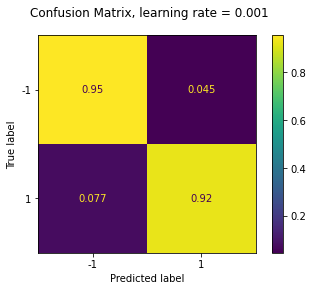

0.9109255393180237
0.9388888888888889


C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


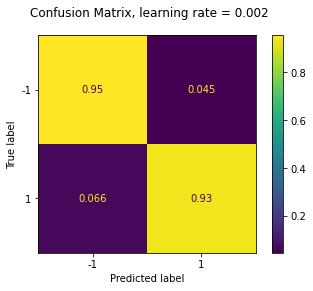

0.9144050104384134
0.9444444444444444


C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


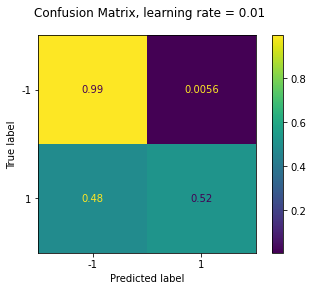

0.7731384829505915
0.7527777777777778


In [19]:
## your code
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle(f"Confusion Matrix, learning rate = {clf.eta}")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
RATE=[0, 0.001, 0.002, 0.01]
metrics
for rate in RATE:
    model = CustomLogisticRegression(eta=rate)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc)
    print(test_acc)
    

For a zero learning rate, model is simply not trained, and has a very low F1 score. For a too high learning rate (0,01), the model has a high False Positive score (0.48) and too low True Negative score (0.52). It may be concluded that for a high learning rate, model makes more preference for a certain class.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


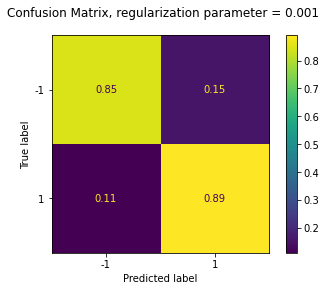

0.8385525400139179
0.8694444444444445


C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


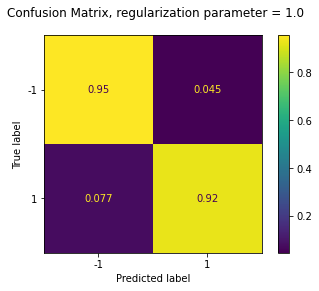

0.9109255393180237
0.9388888888888889


C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


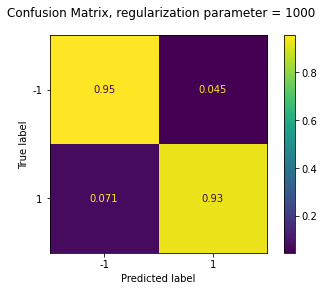

0.9144050104384134
0.9416666666666667


In [20]:
## your code
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle(f"Confusion Matrix, regularization parameter = {clf.C}")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
PTR=[0.001, 1.0, 1000]
metrics
for ptr in PTR:
    model = CustomLogisticRegression(C=ptr)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc)
    print(test_acc)

Stronger regularization (C=0.001) worsens model (F1 = 0.81) compared to the models with the less strong regularization (C=1, C=1000). They have considerably high F1 score, but do not much differ from each other, being relatively equal (0.93 and 0.94)

**(0.5 points)** Compare zero initialization and random initialization. 

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


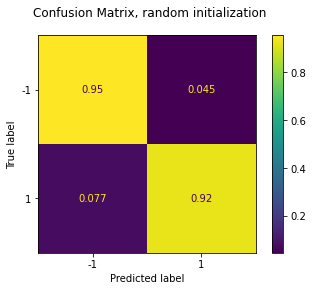

0.9109255393180237
0.9388888888888889


In [21]:
## your code
model = CustomLogisticRegression(zero_init=False)
model.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(model, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix, random initialization")
plt.show()
print(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
print(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


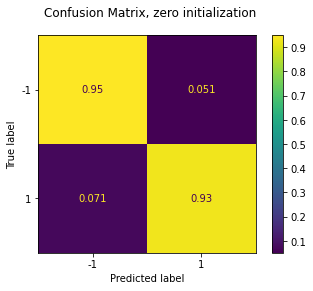

0.9116214335421016
0.9388888888888889


In [22]:
model = CustomLogisticRegression(zero_init=True)
model.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(model, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix, zero initialization")
plt.show()
print(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
print(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

Models with zero and random initialization almost do not differ, and have almost equal F1 scores. However, model with zero initialization has slightly bigger values on false positive and false negaive rates. It also has better true negative value.

In [23]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        res=np.zeros((X.shape[0], Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                res[i][j]=(np.sum((X[i]-Y[j])**2))**0.5
        return res
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        n=len(self.classes_)
        dic={}
        for i in range(n):
            dic[self.classes_[i]]=i
        res=np.zeros(n)
        for i in range(len(weights)):
            res[dic[y[i]]] += weights[i]
        return res
            
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
            res = np.zeros((X.shape[0], len(self.classes_)))
            for i in range(X.shape[0]):
                neibs = (np.argsort(P[i])[:self.n_neighbors])
                neibs_w = self.get_class_weights(self.y[neibs], (weights_of_points[i])[neibs])
                res[i]=neibs_w/np.sum(neibs_w)
            # <your code>
            return res
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        probs=self.predict_proba(X)
        y=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y[i]=self.classes_[np.argmax(probs[i])]
        return y

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

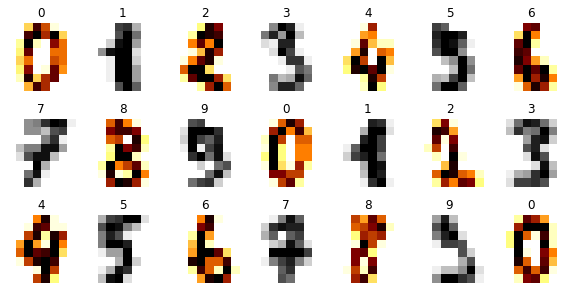

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
y_train[1253]

6

In [31]:
model.predict_proba(X_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
knn.predict_proba(X_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


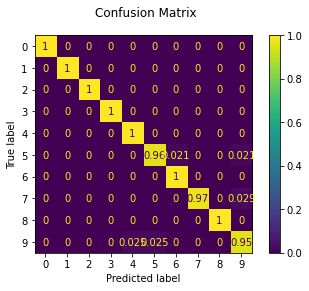

In [34]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [35]:
train_acc

1.0

In [36]:
test_acc

0.9861111111111112

In [37]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Model struggles to recognize the digit 9. It recognizes 9 as 4 or 5 in some cases. It can happen because of the similarity of these digits. It also recognizes the digit 7 as 9 and 6 as 5 due to the same reasons. 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [38]:
## your code
k_values = np.arange(1, 16)
metrics_values = []
for k in k_values:
    model=model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    metrics_values.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))


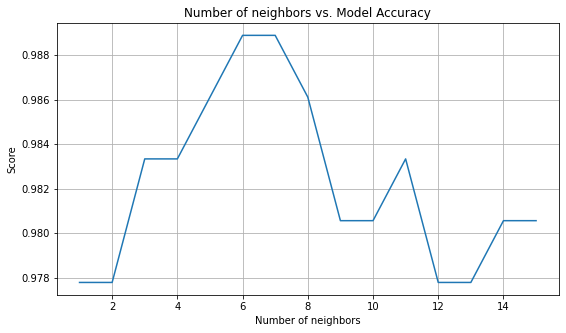

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(k_values, metrics_values)
plt.title('Number of neighbors vs. Model Accuracy')
plt.xlabel('Number of neighbors')
plt.ylabel('Score')
plt.grid(True)

It can be seen that models with different number of neighborhoods parameter have little differences in accuracy. However, it can be seen that the best choices are k equal 6 and 7, and the worst choises are k equal 1, 12, and 13.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


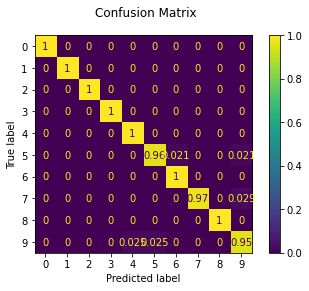

1.0
0.9861111111111112


In [40]:
## your code
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(train_acc)
print(test_acc)

C:\Users\77716\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


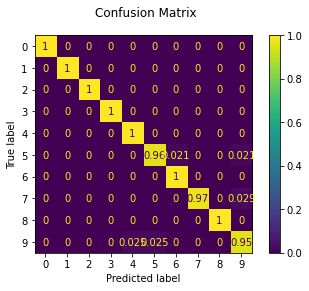

0.9895615866388309
0.9861111111111112


In [41]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(train_acc)
print(test_acc)

Models have almost no differences in accuracy. However, a model with uniform weights has worse accuracy on training data. In this situation distance weights model is a better choice. Distance weights parameter would be better in situations where the distance between neighbors is important.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Manhattan distance coulb be used to improve a model. It works well when we have a large number of features, as in our case.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Cosine distance is another distance function, that can be used in KNN model. It would be a good choice for tasks of analyzing documents and texts symilarities.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [42]:
PATH = ""

In [43]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [44]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [45]:
## your code
data.groupby('Sex').Sex.count()

Sex
female    43886
male      56114
Name: Sex, dtype: int64

There are relatively equal distribution of male and female passengers.

In [46]:
data.groupby(['Survived', 'Sex']).Survived.count()

Survived  Sex   
0         female    12660
          male      44566
1         female    31226
          male      11548
Name: Survived, dtype: int64

It can be seen that female passengers has a high survival ratio (31226 against 12660) compared to the male passengers (11548 against 44566). Women had higher chances to survive than men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

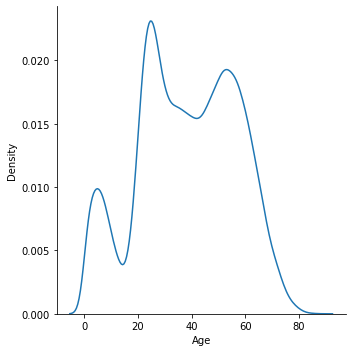

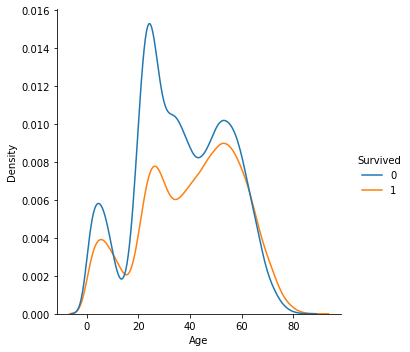

In [47]:
## your code
sns.displot(data, x='Age', kind='kde')
sns.displot(data, x='Age', hue='Survived', kind='kde')

In [48]:
surv_mean=data[data.Survived==1]['Age'].mean()
surv_med=data[data.Survived==1]['Age'].median()
dec_mean=data[data.Survived==0]['Age'].mean()
dec_med=data[data.Survived==0]['Age'].median()
print(f'The mean age of survived passengers is {surv_mean}')
print(f'The median age of survived passengers is {surv_med}')
print(f'The mean age of deceased passengers is {dec_mean}')
print(f'The median age of deceased passengers is {dec_med}')

The mean age of survived passengers is 40.553799314307795
The median age of survived passengers is 43.0
The mean age of deceased passengers is 36.70869488153374
The median age of deceased passengers is 36.0


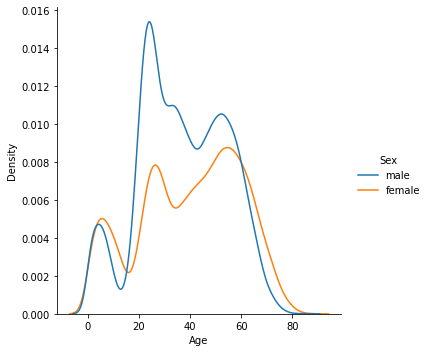

In [49]:
sns.displot(data, x='Age', hue='Sex', kind='kde')

It can be seen from the distribution graph that number of survived people in the age of 20-40 were considerably less than those who deceased. It also seen from the mean and median ages, where those values of deceased passengers is smaller than survived. The explanation of that is seen in the third graph: the number of female passengers in the ages of 20-40 is less tham male passengers in that ages.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

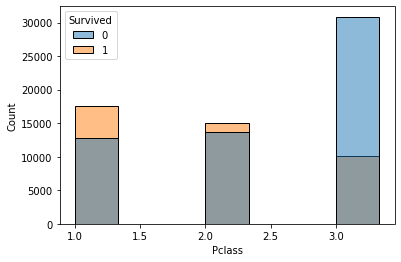

In [50]:
## your code
sns.histplot(data=data, x='Pclass', hue='Survived', binwidth = 1/3)

The first class was the safest. There are biggest number of survived people and the highest survival ratio.

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

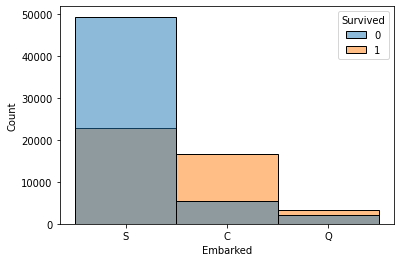

In [51]:
sns.histplot(data=data, x='Embarked', hue='Survived', binwidth = 1/3)

Although port S has the biggest number of survived people, it has a lowest survival ratio. Port C has more people than the port Q, and has better survuval ratio, so it can be stated that the port C was safest.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [52]:
## your code
data.isna().sum()/data.shape[0]*100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

5 features have missing values: Age with 3.3%, Ticket with 4.6%, Fare with 0.1%, Cabin with 67.9% and Embarked with 0.3%.

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Cabin feature has a vey high percentage of missing valued, and it is also categorical feature. So we can just ignore this column. Ticket column has unique values, so we can ignore it too. Instead, we will use the firslt letter of these features, and fill nan ticket values with 'X' and nan cabin balues with class number. For age and fare feature, we can replace NaN values with the median. Embarked features have realtively small percentage of missing values and we will replace Nan values with the most common port: S port.

In [53]:
data['Age']=data['Age'].fillna(data['Age'].median())
data['Fare']=data['Fare'].fillna(data['Fare'].median())
data['Embarked']=data['Embarked'].fillna('S')

In [54]:
data.isna().sum()/data.shape[0]*100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          0.000
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.000
Cabin       67.866
Embarked     0.000
dtype: float64

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [55]:
data['relatives'] = data['SibSp']+data['Parch']
data['is_teen'] = (data['Age'] < 19)
data['adult'] = ((data['Age'] >= 19) & (data['Age'] < 45))
data['old'] = (data['Age'] >= 45)
data['alone'] = (data['relatives'] == 0)
data['TicketLetter'] = data['Ticket'].str.upper().str[:1]
data['TicketLetter'] = data['TicketLetter'].fillna('X')
data['CabinLetter'] = data['Cabin'].str.upper().str[:1]
data['CabinLetter'] = data['CabinLetter'].fillna(data["Pclass"])
data['CabinLetter'] = data['CabinLetter'].map(str)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,is_teen,adult,old,alone,TicketLetter,CabinLetter
PassengerId,,,,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,39.00,2,0,209245,27.14,C12239,S,2,False,True,False,False,2,C
1,0,3,"Bryan, Drew",male,39.00,0,0,27323,13.35,NaN,S,0,False,True,False,True,2,3
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,3,True,False,False,False,C,3
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0,False,True,False,True,A,3
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,0,False,True,False,True,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C,0,False,False,True,True,P,D
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S,0,False,False,True,True,1,2
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S,0,False,True,False,True,X,3


In [56]:
SEED=42
np.random.seed(SEED)

In [57]:
## your code
num_features=['Age', 'relatives', 'Fare']
cat_features=['Sex', 'Embarked', 'Pclass']
target='Survived'
def make_model(model_type='knn', n_neighbors=5, C=0.12, weights='distance'):
    if model_type == 'log':
        model=linreg = LogisticRegression(C=C, max_iter=1000, tol=1e-5, penalty='l2')
    else:
        model=KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    preprocessor = make_column_transformer(
            (StandardScaler(), num_features),
            (OneHotEncoder(), cat_features)
    )
    return Pipeline([
        ('pre', preprocessor),
        ('mod', model)
    ])

In [58]:
X=data[num_features+cat_features]
y=data[target]

In [59]:
acc_train, acc_valid = 0, 0
results = cross_validate(make_model(model_type='log'), 
                         X, y, cv=5,
                         return_train_score=True,
                         scoring='accuracy')
acc_train=(np.mean(results['train_score']))
acc_valid=(np.mean(results['test_score']))

In [60]:
print(acc_train)
print(acc_valid)

0.764285
0.7642599999999999


In [61]:
acc_train, acc_valid = 0, 0
results = cross_validate(make_model(model_type='knn', n_neighbors=2), 
                         X, y, cv=5,
                         return_train_score=True,
                         scoring='accuracy')
acc_train=(np.mean(results['train_score']))
acc_valid=(np.mean(results['test_score']))

In [62]:
print(acc_train)
print(acc_valid)

0.9937400000000001
0.68902


Logistic Regression model has a stable accuracy values (~0.76), while KNN model has high train accuracy and low validation accuracy. It can indicate that KNN model is overfitted.

### (0.5 + X points) Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).



In [63]:
## your code
num_features=['Age', 'relatives', 'Fare', 'SibSp', 'Parch']
cat_features=['Sex', 'Embarked', 'Pclass', 'is_teen', 'adult', 'old', 'TicketLetter', 'CabinLetter']
target='Survived'
def make_model(model_type='knn', n_neighbors=5, C=0.12, weights='distance'):
    if model_type == 'log':
        model=linreg = LogisticRegression(C=C, max_iter=10000, tol=1e-5, penalty='l2')
    else:
        model=KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    preprocessor = make_column_transformer(
            (StandardScaler(), num_features),
            (OneHotEncoder(), cat_features)
    )
    return Pipeline([
        ('pre', preprocessor),
        ('mod', model)
    ])

In [64]:
X=data[num_features+cat_features]
y=data[target]

In [65]:
acc_train, acc_valid = 0, 0
results = cross_validate(make_model(model_type='log'), 
                         X, y, cv=5,
                         return_train_score=True,
                         scoring='accuracy')
acc_train=(np.mean(results['train_score']))
acc_valid=(np.mean(results['test_score']))

In [66]:
print(acc_train)
print(acc_valid)

0.7767424999999999
0.77669


In [67]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data['Age']=data['Age'].fillna(data['Age'].median())
data['Fare']=data['Fare'].fillna(data['Fare'].median())
data['Embarked']=data['Embarked'].fillna('S')
data['relatives'] = data['SibSp']+data['Parch']
data['is_teen'] = (data['Age'] < 19)
data['adult'] = ((data['Age'] >= 19) & (data['Age'] < 45))
data['old'] = (data['Age'] >= 45)
data['alone'] = (data['relatives'] == 0)
data['TicketLetter'] = data['Ticket'].str.upper().str[:1]
data['TicketLetter'] = data['TicketLetter'].fillna('X')
data['CabinLetter'] = data['Cabin'].str.upper().str[:1]
data['CabinLetter'] = data['CabinLetter'].fillna(data["Pclass"])
data['CabinLetter'] = data['CabinLetter'].map(str)
data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,is_teen,adult,old,alone,TicketLetter,CabinLetter
PassengerId,,,,,,,,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,0,False,True,False,True,2,3
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,0,False,False,True,True,1,3
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,0,False,True,False,True,2,B
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,0,False,True,False,True,3,2
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,2,True,False,False,False,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q,0,False,True,False,True,7,3
199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S,1,False,False,True,False,1,1
199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S,0,False,False,True,True,4,3


In [68]:
X_test=data[num_features + cat_features]
model = make_model(model_type='log')
model.fit(X, y)
y_test=model.predict(X_test)
data['Survived']=y_test
data.reset_index()[['PassengerId', 'Survived']].to_csv("output4.csv", index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.